# **Project 2 (Bag-of-words classifier)**

## Mount Drive and Verify Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/CVPR2025/Project_2"
DATA_PATH = os.path.join(PROJECT_PATH, "data")

print("Train categories:")
print(os.listdir(os.path.join(DATA_PATH, "train")))

print("\nTest categories:")
print(os.listdir(os.path.join(DATA_PATH, "test")))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train categories:
['Highway', 'Bedroom', 'Industrial', 'Forest', 'Coast', 'InsideCity', 'Kitchen', 'Mountain', 'LivingRoom', 'Office', 'TallBuilding', 'Street', 'OpenCountry', 'Store', 'Suburb']

Test categories:
['Industrial', 'Bedroom', 'Coast', 'Kitchen', 'Highway', 'LivingRoom', 'InsideCity', 'Forest', 'Office', 'Mountain', 'OpenCountry', 'Store', 'Suburb', 'TallBuilding', 'Street']


## STEP 1: Building a Visual Vocabulary

### Sampling SIFT Descriptors

In [ ]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm

# Paths
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/CVPR2025/Project_2"
TRAIN_PATH = os.path.join(PROJECT_PATH, "data", "train")

# Parameters
TARGET_DESCRIPTORS = 100000  #  10K–100K
MAX_PER_IMAGE = 66       # cap per image
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Initialize SIFT
sift = cv2.SIFT_create()

all_descriptors = []

# Iterate over categories
categories = sorted(os.listdir(TRAIN_PATH))

for category in categories:
    category_path = os.path.join(TRAIN_PATH, category)
    if not os.path.isdir(category_path):
        continue

    image_files = os.listdir(category_path)

    for img_name in tqdm(image_files, desc=f"SIFT {category}"):
        if len(all_descriptors) >= TARGET_DESCRIPTORS:
            break

        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is None:
            continue

        # Randomly sample descriptors from this image
        descriptors = descriptors.astype(np.float32)
        if len(descriptors) > MAX_PER_IMAGE:
            idx = np.random.choice(len(descriptors), MAX_PER_IMAGE, replace=False)
            descriptors = descriptors[idx]

        for d in descriptors:
            all_descriptors.append(d)
            if len(all_descriptors) >= TARGET_DESCRIPTORS:
                break

    if len(all_descriptors) >= TARGET_DESCRIPTORS:
        break

all_descriptors = np.array(all_descriptors)
print("Total sampled descriptors:", all_descriptors.shape)



SIFT TallBuilding: 100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


Total sampled descriptors: (98496, 128)


In [ ]:
# OPTIONALLY SAVE THE SIFT DESCRIPTORS TO AVOID RECOMPUTING SIFT EVERY TIME
np.save(os.path.join(PROJECT_PATH, "sift_samples.npy"), all_descriptors)

# TO REALOAD LATER USE THIS
#all_descriptors = np.load(os.path.join(PROJECT_PATH, "sift_samples.npy"))


VISUALISE

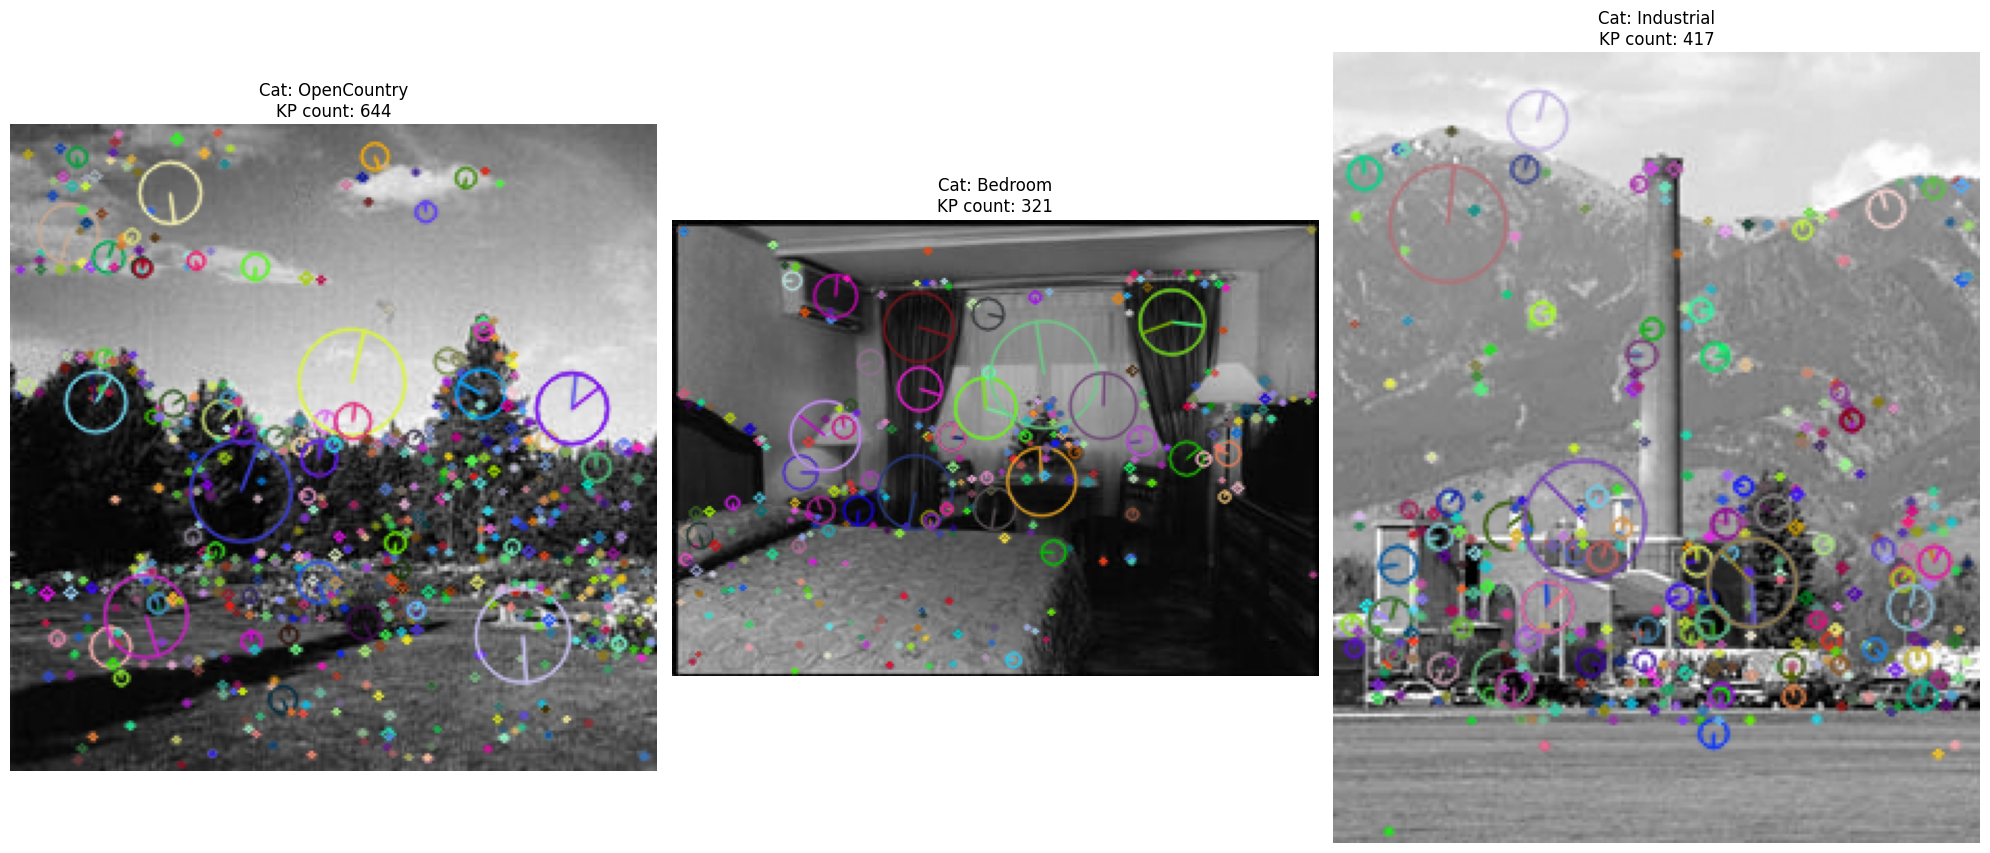

In [ ]:
import matplotlib.pyplot as plt
import random

def visualize_sift_multi_sample(train_path, categories, num_samples=3):
    # Set up the figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 10))

    for i in range(num_samples):
        # 1. Pick random category and image
        random_category = random.choice(categories)
        category_path = os.path.join(train_path, random_category)
        img_list = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        random_img_name = random.choice(img_list)
        img_path = os.path.join(category_path, random_img_name)

        # 2. Process image
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 3. SIFT Detection
        kp = sift.detect(gray, None)

        # 4. Draw Rich Keypoints
        img_with_kp = cv2.drawKeypoints(img, kp, None,
                                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # 5. Display on the specific subplot axis
        axes[i].imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Cat: {random_category}\nKP count: {len(kp)}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Run it to see 3 samples
visualize_sift_multi_sample(TRAIN_PATH, categories)

k-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
import joblib # Useful for saving the model

# 1. Define the number of clusters (Visual Words)
K_WORDS = 150

print(f"Clustering {len(all_descriptors)} descriptors into {K_WORDS} visual words...")

# 2. Initialize and fit KMeans
# n_init='auto' is faster; random_state ensures reproducibility
kmeans = KMeans(n_init=10, n_clusters=K_WORDS, random_state=RANDOM_SEED, verbose=1)
kmeans.fit(all_descriptors)

# 3. Extract the Visual Vocabulary (Centroids)
# Each centroid is a 128-dimensional vector representing a "Visual Word"
vocabulary = kmeans.cluster_centers_
print("Vocabulary shape:", vocabulary.shape)


# 4. Save the vocabulary and the kmeans object
VOCAB_PATH = os.path.join(PROJECT_PATH, "visual_vocabulary.pkl")
joblib.dump(kmeans, VOCAB_PATH)

print(f"Vocabulary saved to {VOCAB_PATH}")

Clustering 98496 descriptors into 150 visual words...
Initialization complete
Iteration 0, inertia 11372182528.0.
Iteration 1, inertia 8014769152.0.
Iteration 2, inertia 7855805952.0.
Iteration 3, inertia 7788573696.0.
Iteration 4, inertia 7749397504.0.
Iteration 5, inertia 7722923520.0.
Iteration 6, inertia 7703803904.0.
Iteration 7, inertia 7689971200.0.
Iteration 8, inertia 7679965184.0.
Iteration 9, inertia 7672074752.0.
Iteration 10, inertia 7665953280.0.
Iteration 11, inertia 7660723200.0.
Iteration 12, inertia 7655994880.0.
Iteration 13, inertia 7651774464.0.
Iteration 14, inertia 7648282112.0.
Iteration 15, inertia 7645244416.0.
Iteration 16, inertia 7642294784.0.
Iteration 17, inertia 7639730688.0.
Iteration 18, inertia 7637443584.0.
Iteration 19, inertia 7635198464.0.
Iteration 20, inertia 7633009664.0.
Iteration 21, inertia 7630830080.0.
Iteration 22, inertia 7628680704.0.
Iteration 23, inertia 7626918400.0.
Iteration 24, inertia 7625290752.0.
Iteration 25, inertia 762392268

Saving the centroids


In [ ]:
# 1. Extract the centroids (the k visual words)
visual_words = kmeans.cluster_centers_

# 2. Save them as a standalone NumPy file for easy loading later
VOCAB_ARRAY_PATH = os.path.join(PROJECT_PATH, "centroids.npy")
np.save(VOCAB_ARRAY_PATH, visual_words)

print(f"Successfully saved {visual_words.shape[0]} visual words of {visual_words.shape[1]} dimensions.")
print(f"File saved at: {VOCAB_ARRAY_PATH}")

Successfully saved 150 visual words of 128 dimensions.
File saved at: /content/drive/MyDrive/Colab Notebooks/CVPR2025/Project_2/centroids.npy


## STEP 2: Representing each image of the training set as a normalized histogram

In [ ]:
def extract_bow_histogram(img, sift_provider, kmeans_model, k):
    """
    Converts an image into a normalized BoW histogram.
    """
    # 1. Extract descriptors
    # No limit on descriptors per image here; we want the "full picture"
    kp, descriptors = sift_provider.detectAndCompute(img, None)

    # Initialize an empty histogram in case no descriptors are found
    hist = np.zeros(k, dtype=np.float32)

    if descriptors is not None:
        descriptors = descriptors.astype(np.float32)

        # 2. Assign each descriptor to the nearest visual word (cluster center)
        # kmeans.predict returns the index (0 to k-1) for each descriptor
        words = kmeans_model.predict(descriptors)

        # 3. Build the histogram
        # bins=range(k+1) ensures we have exactly k bins
        hist, _ = np.histogram(words, bins=range(k + 1))

        # 4. Normalize (L1 norm)
        # We add a small epsilon to avoid division by zero
        sum_val = np.sum(hist)
        if sum_val > 0:
            hist = hist.astype(np.float32) / sum_val

    return hist



# --- Process the whole training set ---

print("\nProcessing the training set...")
train_histograms = []
train_labels = []

for category_id, category in enumerate(categories):
    category_path = os.path.join(TRAIN_PATH, category)
    if not os.path.isdir(category_path):
        continue

    image_files = os.listdir(category_path)
    for img_name in tqdm(image_files, desc=f"Representing {category}"):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue

        # Get the histogram
        hist = extract_bow_histogram(img, sift, kmeans, K_WORDS)

        train_histograms.append(hist)
        train_labels.append(category_id)

# Convert to numpy arrays for the classifier
X_train = np.array(train_histograms)
y_train = np.array(train_labels)

print("\nTraining data ready.")
print("X_train shape:", X_train.shape) # Should be (NumImages, K_WORDS)
print("y_train shape:", y_train.shape)


Processing the training set...


Representing TallBuilding: 100%|██████████| 100/100 [00:06<00:00, 14.34it/s]


Training data ready.
X_train shape: (1500, 150)
y_train shape: (1500,)


Visualise a few histograms:

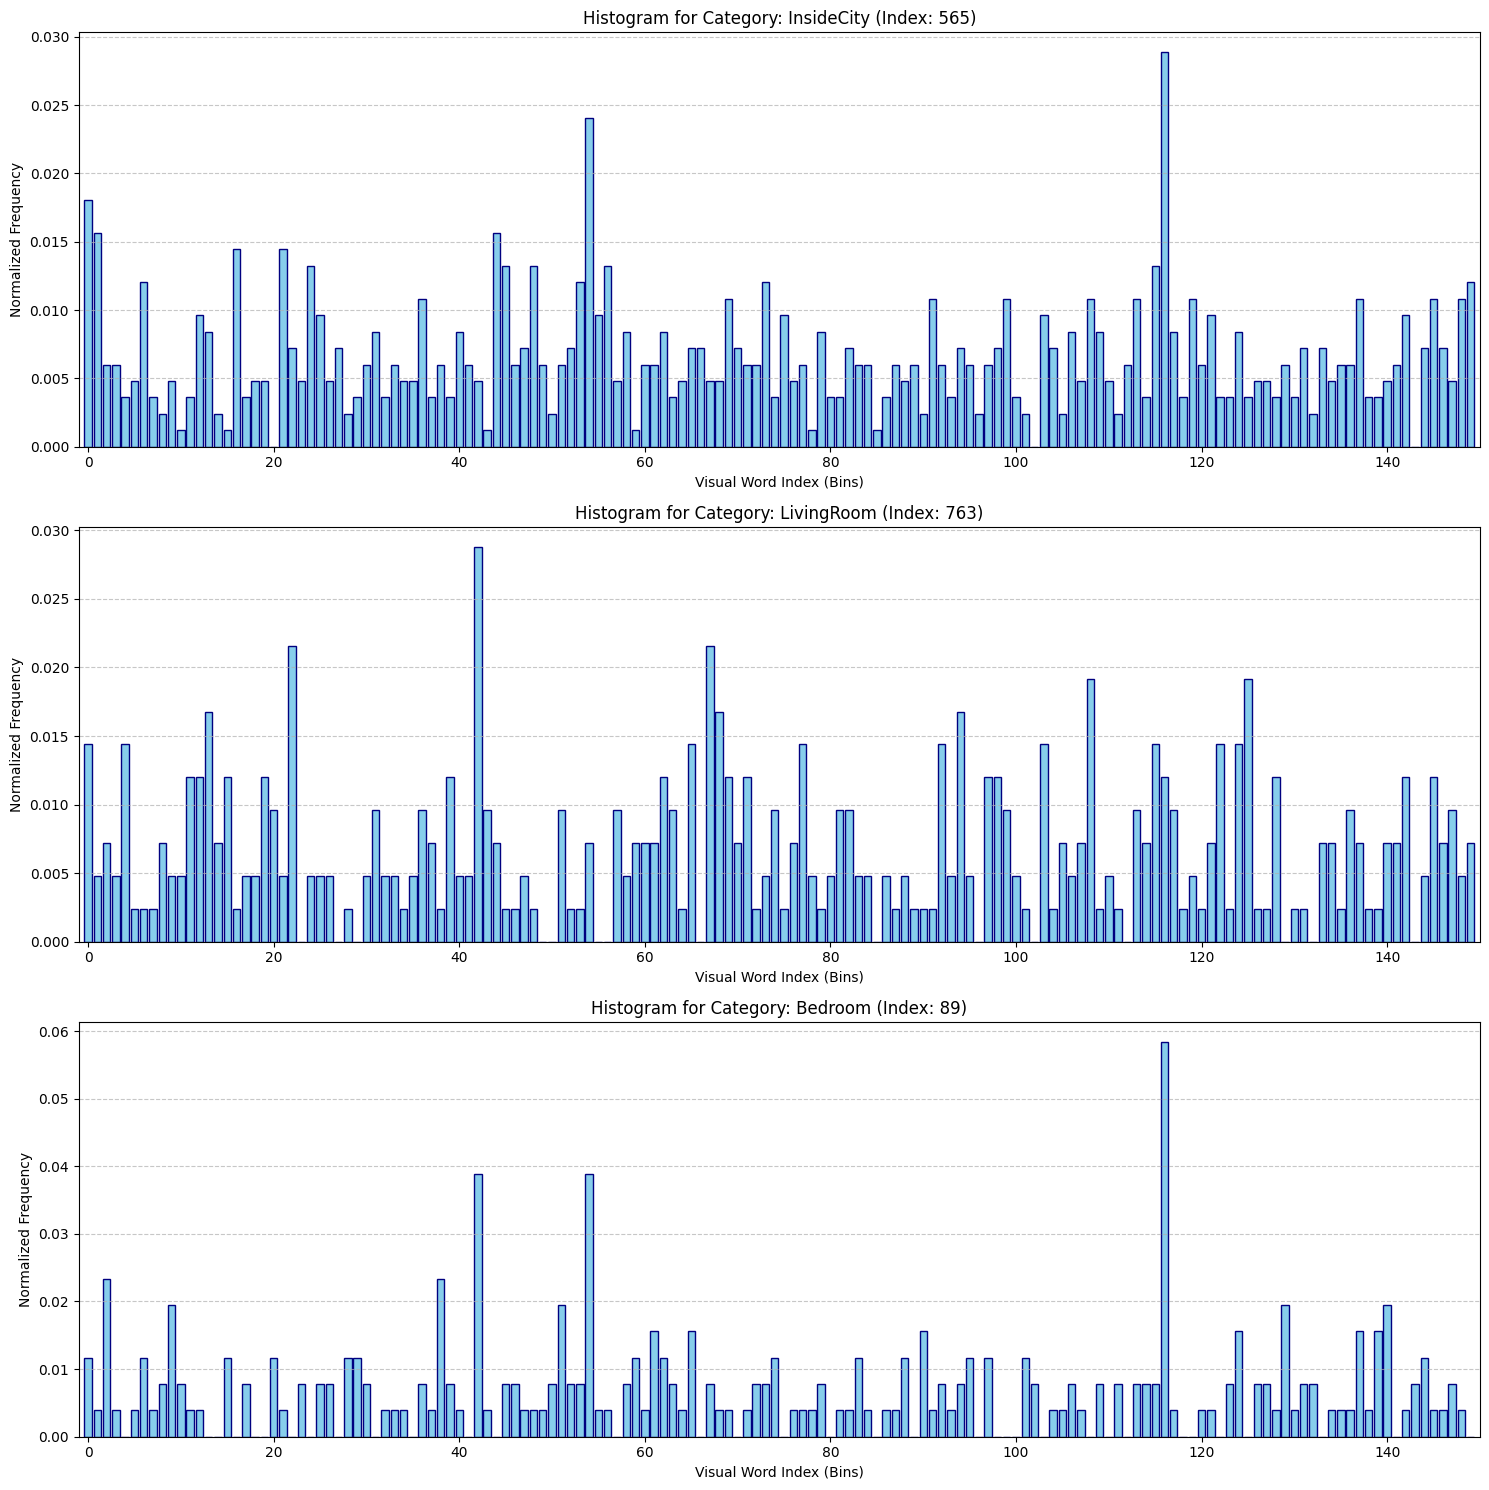

In [ ]:
import matplotlib.pyplot as plt

def visualize_histograms(X, y, categories, num_examples=3):
    """
    Plots histograms for a few sample images.
    """
    plt.figure(figsize=(15, 5 * num_examples))

    # Pick random indices to visualize
    indices = np.random.choice(len(X), num_examples, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(num_examples, 1, i + 1)

        # Plotting the histogram bins
        plt.bar(range(len(X[idx])), X[idx], color='skyblue', edgecolor='navy')

        plt.title(f"Histogram for Category: {categories[y[idx]]} (Index: {idx})")
        plt.xlabel("Visual Word Index (Bins)")
        plt.ylabel("Normalized Frequency")
        plt.xlim(-1, len(X[idx]))
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Visualize 3 random histograms from your processed training set
visualize_histograms(X_train, y_train, categories, num_examples=3)

## Step 3: Employ a nearest neighbor classifier and evaluate its performance

Computing the normalised histogram for the TEST images


In [ ]:
# FIRST WE PROCESS THE TEST SET

print("\nProcessing the Test set...")
TEST_PATH = os.path.join(PROJECT_PATH, "data", "test")

test_histograms = []
test_labels = []

# Ensure categories match the training order
for category_id, category in enumerate(categories):
    category_path = os.path.join(TEST_PATH, category)
    if not os.path.isdir(category_path):
        continue

    image_files = os.listdir(category_path)
    for img_name in tqdm(image_files, desc=f"Representing Test {category}"):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue

        # Use the same function as before
        hist = extract_bow_histogram(img, sift, kmeans, K_WORDS)

        test_histograms.append(hist)
        test_labels.append(category_id)

# Convert to numpy arrays
X_test = np.array(test_histograms)
y_test = np.array(test_labels)

print("\nTesting data ready.")
print("X_test shape:", X_test.shape) # (NumTestImages, K_WORDS)
print("y_test shape:", y_test.shape)


Processing the Test set...


Representing Test TallBuilding: 100%|██████████| 256/256 [00:18<00:00, 13.91it/s]


Testing data ready.
X_test shape: (2985, 150)
y_test shape: (2985,)


Let's view a few histograms for the test images

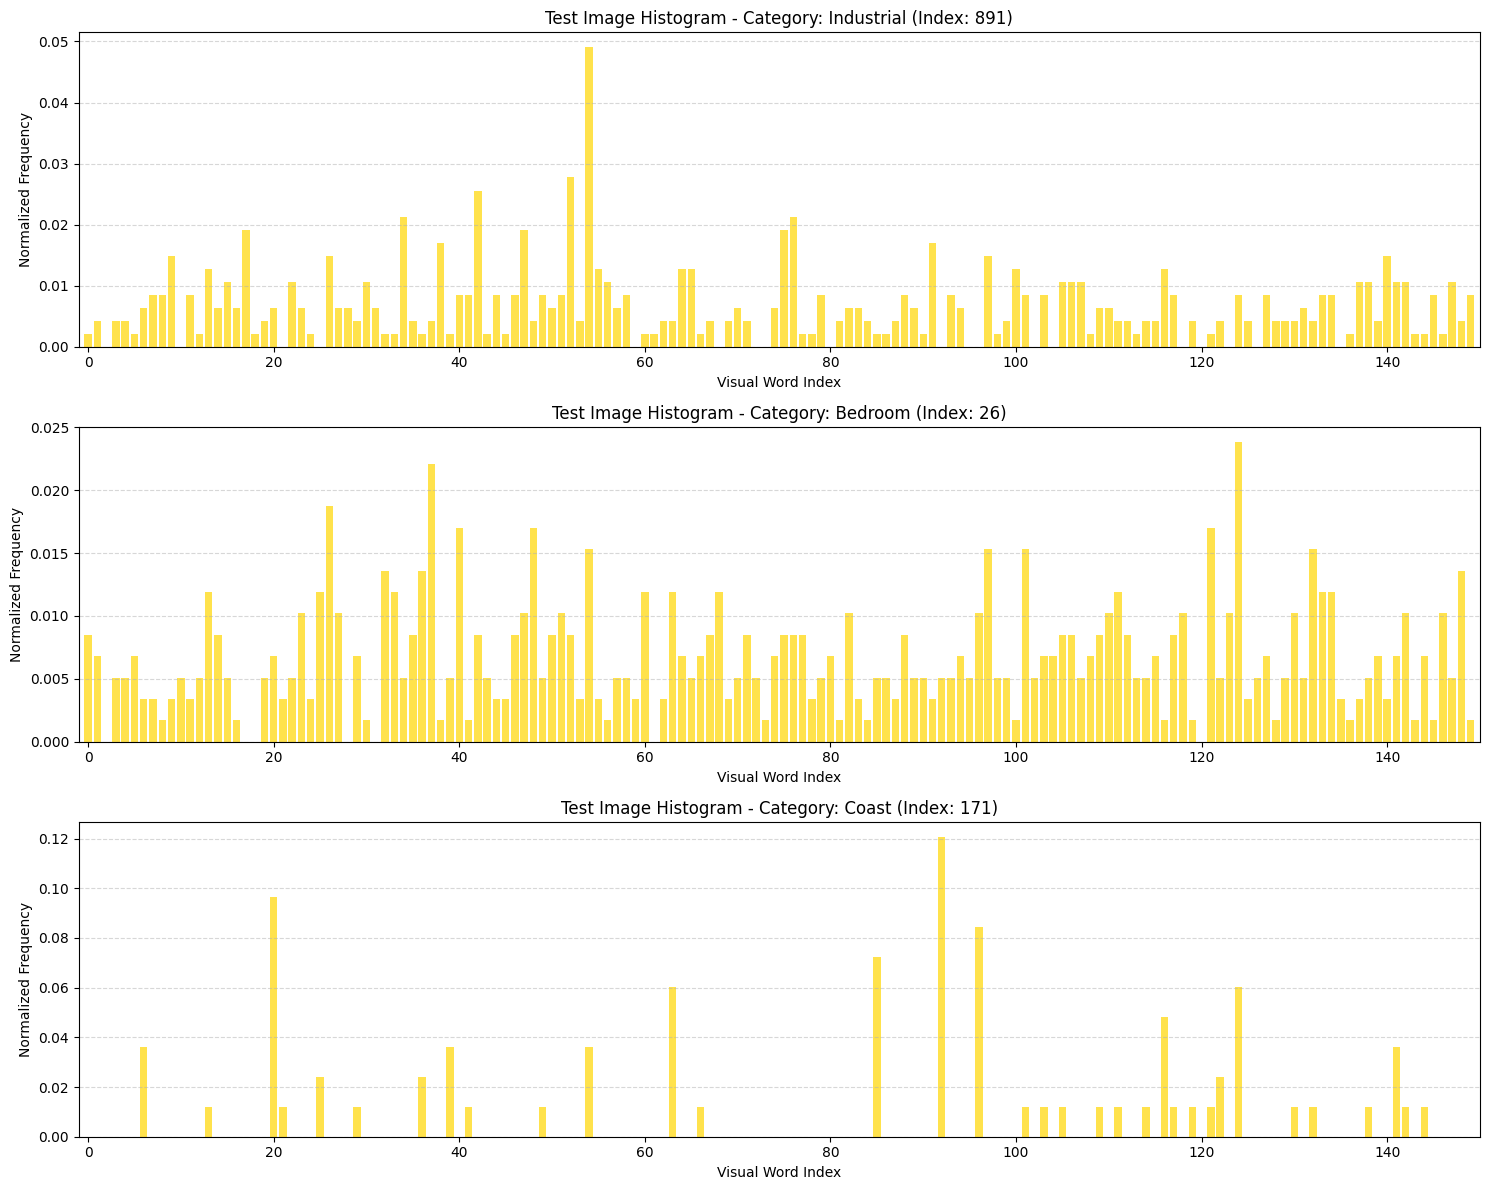

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_test_histograms(X, y, category_names, num_samples=3):
    """
    Plots normalized histograms for a selection of test images.
    """
    # Select random indices from the test set
    indices = np.random.choice(len(X), num_samples, replace=False)

    plt.figure(figsize=(15, 4 * num_samples))

    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 1, i + 1)

        # Plot the 200 bins of the BoW histogram
        plt.bar(range(len(X[idx])), X[idx], color='gold', alpha=0.7)

        plt.title(f"Test Image Histogram - Category: {category_names[y[idx]]} (Index: {idx})")
        plt.xlabel("Visual Word Index")
        plt.ylabel("Normalized Frequency")
        #plt.ylim(0, np.max(X) * 1.1)  # Scale y-axis slightly above max value for clarity
        plt.xlim(-1, len(X[idx]))
        plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Call the function to see 3 random test histograms
plot_sample_test_histograms(X_test, y_test, categories, num_samples=3)

Assignign the image class closest to the calculated histogram

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize the Nearest Neighbor (k=1)
# Using metric='euclidean' as per standard BoW distance
nn_classifier = KNeighborsClassifier(n_neighbors=8, metric='euclidean')
#euclidean, manhattan, cosine, chebyshev...

# 2. "Train" (just stores the training histograms)
nn_classifier.fit(X_train, y_train)

# 3. Predict for all test images
y_pred_nn = nn_classifier.predict(X_test)

# 4. Evaluate
accuracy = accuracy_score(y_test, y_pred_nn)
print(f"\nNearest Neighbor Accuracy: {accuracy * 100:.2f}%")


Nearest Neighbor Accuracy: 37.72%


Visualising the confusion matrix

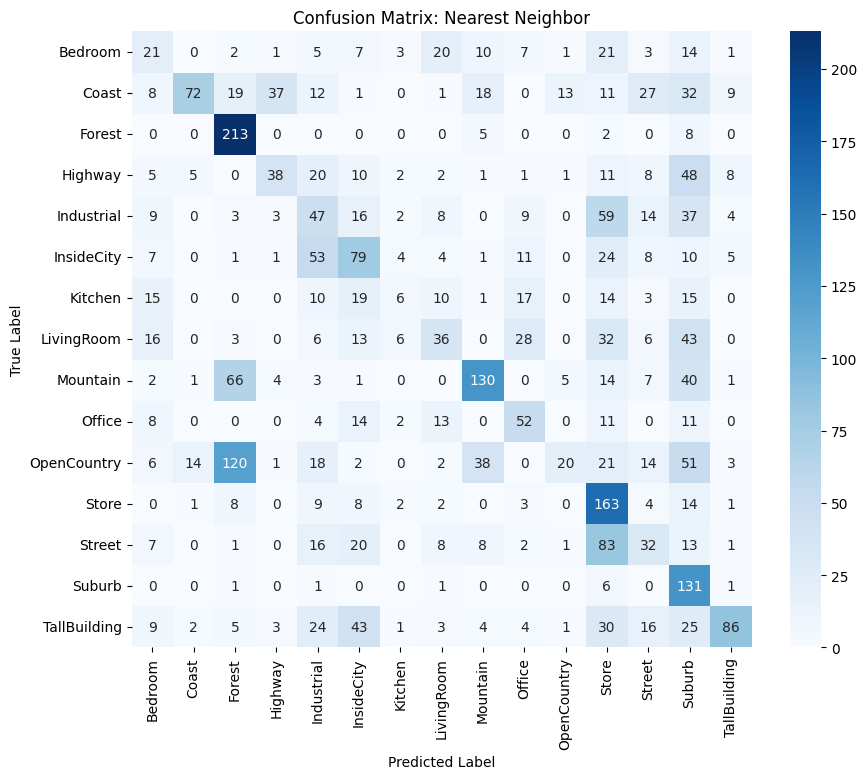

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred_nn, categories, "Confusion Matrix: Nearest Neighbor")

## STEP 4: Training a multiclass linear SVM using OvR approach

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Manual One-vs-Rest Training
# We will store the 15 binary classifiers in a list
binary_classifiers = []

print(f"Training 15 binary SVM classifiers...")

for i in range(len(categories)):
    # Create binary labels: 1 for the current class, 0 for all others
    binary_labels = (y_train == i).astype(int)

    # Initialize the Linear SVM
    # C=1.0 is a standard starting point for regularization
    clf = LinearSVC(C=0.01, random_state=RANDOM_SEED, max_iter=10000, dual=False)
    # Train the binary classifier for this specific category
    clf.fit(X_train_scaled, binary_labels)
    binary_classifiers.append(clf)

print("Training complete.")

Training 15 binary SVM classifiers...
Training complete.


## STEP 5: Evaluating the SVM

In [ ]:
# Initialize a list to store the final predictions
y_pred_svm = []

# We iterate through every test image
# X_test_scaled contains the normalized histograms
for i in range(len(X_test_scaled)):

    # Get the single test histogram
    test_histogram = X_test_scaled[i].reshape(1, -1)

    # --- Compute real-valued output of each SVM ---
    scores = []
    for clf in binary_classifiers:
        # decision_function returns the distance to the hyperplane (the real-valued score)
        # We take [0] because we are passing a single sample
        score = clf.decision_function(test_histogram)[0]
        scores.append(score)

    # --- Assigning the class with the gretest real-valued output ---
    # np.argmax returns the index of the maximum score in the list
    predicted_class = np.argmax(scores)
    y_pred_svm.append(predicted_class)

# Convert list to array for evaluation
y_pred_svm = np.array(y_pred_svm)

print("Evaluation complete.")

Evaluation complete.


Building the confusion matrix

Multiclass SVM Accuracy: 44.05%


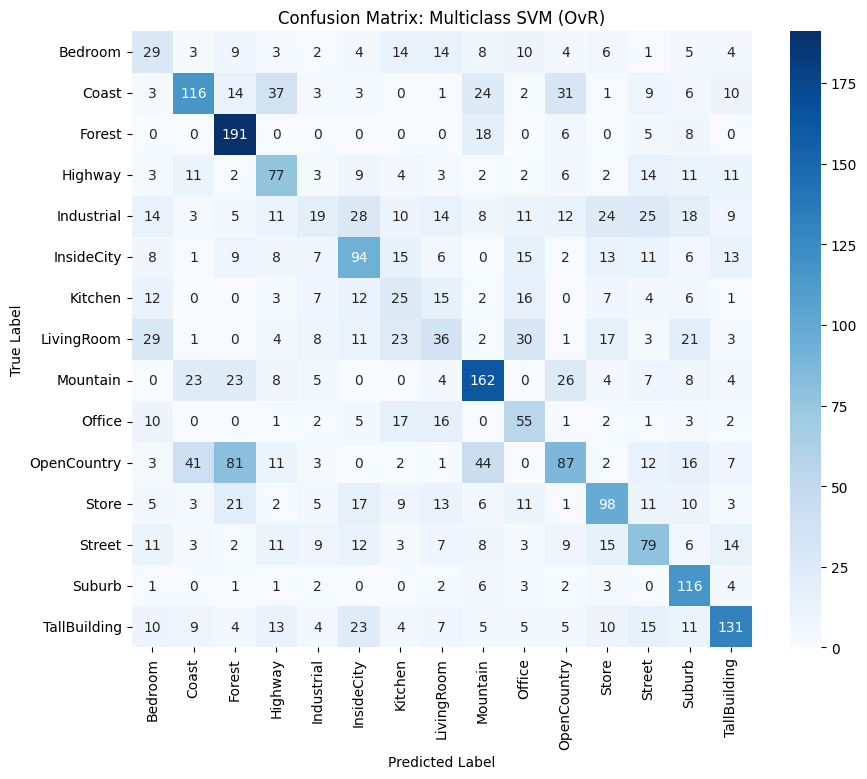

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate Accuracy
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"Multiclass SVM Accuracy: {svm_acc*100:.2f}%")

# Plot the Confusion Matrix
plot_confusion_matrix(y_test, y_pred_svm, categories, "Confusion Matrix: Multiclass SVM (OvR)")

## STEP 6: using a generalised gaussian kernel and CHI-squared distance


--- Step 6: Non-Linear SVM with Chi-Squared Kernel ---
Computing Kernel Matrices...
Kernel Matrix Shape (Train): (1500, 1500)
Training SVM (this may take a moment)...
Predicting on Test Set...

Final Accuracy (Chi-Squared SVM): 58.02%


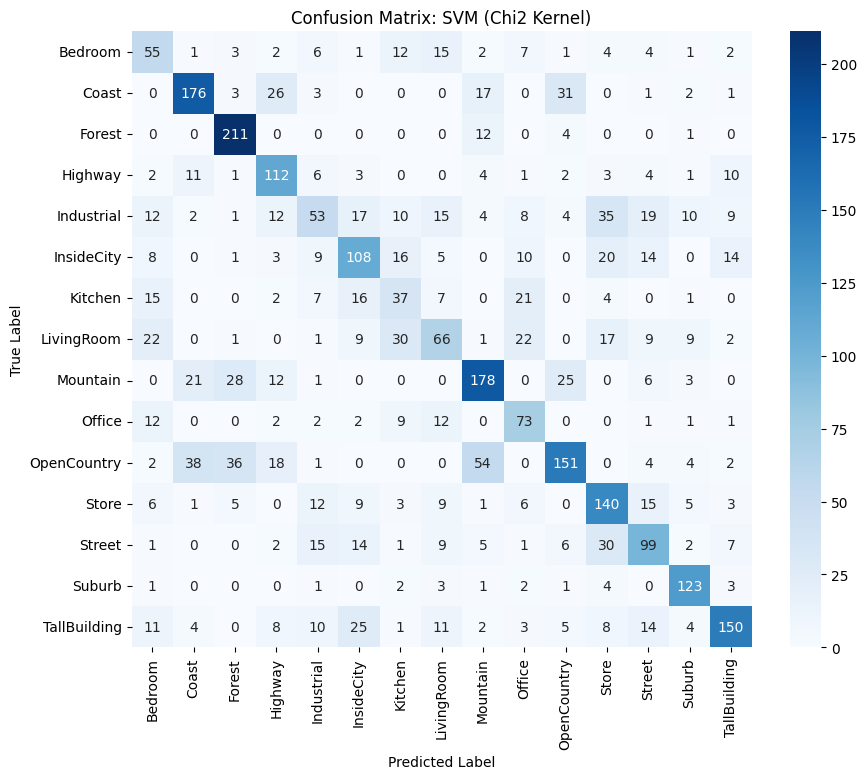

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import chi2_kernel

# ---------------------------------------------------------
# Step 6: Train SVM using Generalized Gaussian Kernel (Chi-squared)
# ---------------------------------------------------------

print("\n--- Step 6: Non-Linear SVM with Chi-Squared Kernel ---")

# 1. Compute the Chi-Squared Kernel Matrix
# We can use sklearn's built-in helper for the distance calculation
# gamma is a hyperparameter. A robust heuristic is 1 / mean(chi2_distance)
# but typically gamma=1.0 or gamma=0.5 works well for normalized histograms.

print("Computing Kernel Matrices...")
# Compute kernel for training (compare train vs train)
K_train = chi2_kernel(X_train, X_train, gamma=2)

# Compute kernel for testing (compare test vs train)
K_test = chi2_kernel(X_test, X_train, gamma=2)

print(f"Kernel Matrix Shape (Train): {K_train.shape}")

# 2. Train the SVM with 'precomputed' kernel
# We use C=10 or C=100 because non-linear kernels often benefit from less regularization
svm_chi2 = SVC(kernel='precomputed', C=1.5, random_state=RANDOM_SEED)

print("Training SVM (this may take a moment)...")
svm_chi2.fit(K_train, y_train)

# 3. Predict and Evaluate
print("Predicting on Test Set...")
y_pred_chi2 = svm_chi2.predict(K_test)

# 4. Accuracy
chi2_acc = accuracy_score(y_test, y_pred_chi2)
print(f"\nFinal Accuracy (Chi-Squared SVM): {chi2_acc * 100:.2f}%")

# 5. Confusion Matrix
plot_confusion_matrix(y_test, y_pred_chi2, categories, "Confusion Matrix: SVM (Chi2 Kernel)")

## STEP 7: Error-Correcting Output code approach



--- Step 7: Multiclass SVM with Error Correcting Output Codes (ECOC) ---
Training ECOC Classifier with code_size=4..
Predicting on Test Set...

Final Accuracy (ECOC SVM): 43.18%


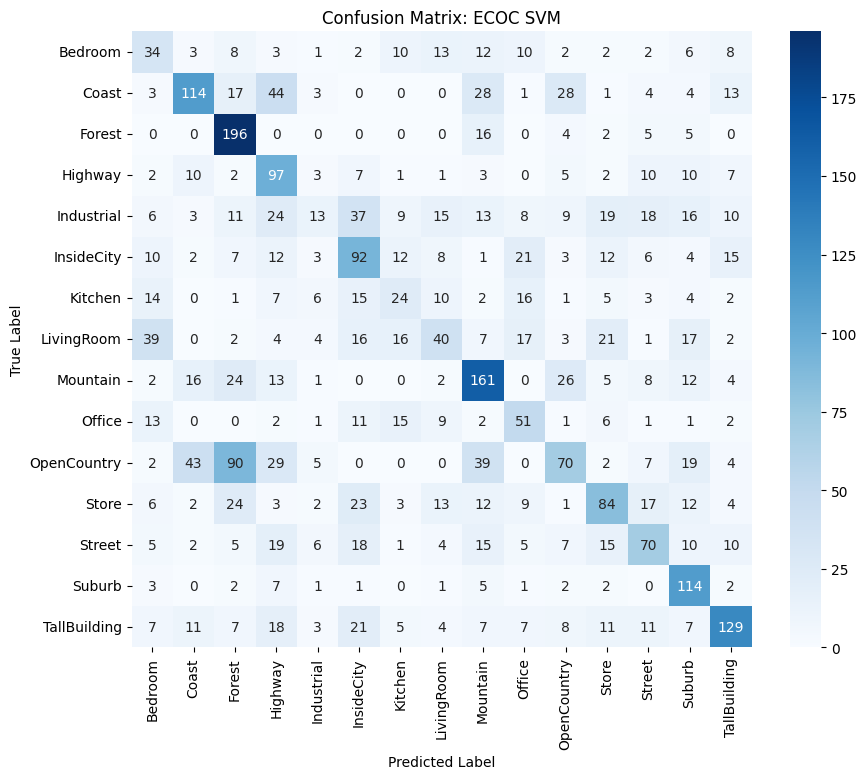

In [ ]:
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

print("\n--- Step 7: Multiclass SVM with Error Correcting Output Codes (ECOC) ---")

# 1. Initialize the Base Classifier
# We use the same LinearSVC as in Step 4 for a fair comparison
# dual=False is usually preferred when n_samples > n_features
base_svm = LinearSVC(C=1, random_state=RANDOM_SEED, dual=False, max_iter=5000)

# 2. Initialize the ECOC Wrapper
# code_size: Scale factor for the codebook.
# code_size=1.5 means we generate (15 classes * 1.5) = ~22 classifiers.
# A larger code size adds more redundancy (error correction) but takes longer to train.
ecoc_clf = OutputCodeClassifier(estimator=base_svm, code_size=5, random_state=RANDOM_SEED)

# 3. Train
# Note: We use the scaled features from Step 4 (StandardScaler)
# SVMs always require scaled data.
print(f"Training ECOC Classifier with code_size=4..")
ecoc_clf.fit(X_train_scaled, y_train)

# 4. Predict
print("Predicting on Test Set...")
y_pred_ecoc = ecoc_clf.predict(X_test_scaled)

# 5. Evaluate
ecoc_acc = accuracy_score(y_test, y_pred_ecoc)
print(f"\nFinal Accuracy (ECOC SVM): {ecoc_acc * 100:.2f}%")

# 6. Confusion Matrix
plot_confusion_matrix(y_test, y_pred_ecoc, categories, "Confusion Matrix: ECOC SVM")

## STEP 8: Soft assigment
In "Hard Assignment" (Step 2), a descriptor that falls halfway between two visual words, say "Edge" and "Corner", is forced to vote 100% for the slightly closer one. This discards valuable ambiguity. Soft Assignment allows that descriptor to vote (e.g.) 55% for "Edge" and 45% for "Corner," preserving the nuance.



###Step 8.1: Determine the Smoothing Parameter ($\sigma$)
We need a $\sigma$ (sigma) for the Gaussian kernel.

- If $\sigma$ is too small, it behaves exactly like Hard Assignment.
- If $\sigma$ is too large, the histogram becomes a flat uniform distribution (useless).

A robust heuristic is to set $\sigma$ to the average distance between descriptors and their nearest visual word.

In [ ]:
# Reload your SIFT samples if they aren't in memory
# all_descriptors = np.load(os.path.join(PROJECT_PATH, "sift_samples.npy"))

# 1. Calculate a dynamic sigma based on your specific data distribution
# We use a subset of descriptors to be fast
sample_indices = np.random.choice(len(all_descriptors), 1000, replace=False)
sample_descriptors = all_descriptors[sample_indices]

# transform() returns the distance to EVERY cluster center
dists = kmeans.transform(sample_descriptors)

# We care about the distance to the NEAREST center for our heuristic
min_dists = np.min(dists, axis=1)

# Set sigma to the average of these distances
sigma = np.mean(min_dists)
print(f"Calculated Sigma for Soft Assignment: {sigma:.4f}")

Calculated Sigma for Soft Assignment: 272.1102


### Step 8.2: Define the Soft Assignment Function
We will create a new extraction function. We use the Gaussian formula:


$$Weight = \exp\left( -\frac{distance^2}{2\sigma^2} \right)$$

In [ ]:
def extract_soft_bow_histogram(img, sift_provider, kmeans_model, k, sigma):
    """
    Computes a Soft-Assignment Bag-of-Words histogram.
    """
    kp, descriptors = sift_provider.detectAndCompute(img, None)

    # Initialize empty histogram
    hist = np.zeros(k, dtype=np.float32)

    if descriptors is not None:
        # 1. Compute distances to ALL k visual words
        # output shape: (n_descriptors, k)
        distances = kmeans_model.transform(descriptors)

        # 2. Convert distances to Gaussian weights (Soft Assignment)
        # We square the distance because transform returns Euclidean distance
        weights = np.exp(- (distances ** 2) / (2 * sigma ** 2))

        # 3. Sum the weights for each visual word (column-wise sum)
        # This effectively lets every descriptor vote for every word based on proximity
        hist = np.sum(weights, axis=0)

        # 4. L1 Normalize the final histogram
        sum_val = np.sum(hist)
        if sum_val > 0:
            hist = hist / sum_val

    return hist

### Step 8.3: Re-Process the Dataset
We must regenerate the histograms for both training and testing sets using this new soft logic.



In [ ]:
print("Extracting Soft-Assignment Histograms...")

X_train_soft = []
y_train_soft = []

# Process Train
for category_id, category in enumerate(categories):
    category_path = os.path.join(TRAIN_PATH, category)
    if not os.path.isdir(category_path): continue

    for img_name in os.listdir(category_path):
        img = cv2.imread(os.path.join(category_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is None: continue

        # Pass the calculated sigma
        hist = extract_soft_bow_histogram(img, sift, kmeans, K_WORDS, sigma)
        X_train_soft.append(hist)
        y_train_soft.append(category_id)

X_train_soft = np.array(X_train_soft)
y_train_soft = np.array(y_train_soft)
print("Processed Train data")


# Process Test
print("Processeing Test data...")
X_test_soft = []
y_test_soft = []

for category_id, category in enumerate(categories):
    category_path = os.path.join(TEST_PATH, category)
    if not os.path.isdir(category_path): continue

    for img_name in os.listdir(category_path):
        img = cv2.imread(os.path.join(category_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is None: continue

        hist = extract_soft_bow_histogram(img, sift, kmeans, K_WORDS, sigma)
        X_test_soft.append(hist)
        y_test_soft.append(category_id)

X_test_soft = np.array(X_test_soft)
y_test_soft = np.array(y_test_soft)
print("Processed Test data")
print(f"Soft histograms ready. Train shape: {X_train_soft.shape}")

Extracting Soft-Assignment Histograms...
Processed Train data
Processeing Test data...
Processed Test data
Soft histograms ready. Train shape: (1500, 150)


### Step 8.4: Evaluation (Linear SVM)

Let's train a standard Linear SVM (One-vs-Rest) on these new features to compare directly with the previous ~37% result.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 1. Scale the soft histograms (Critical for SVM)
scaler_soft = StandardScaler()
X_train_soft_scaled = scaler_soft.fit_transform(X_train_soft)
X_test_soft_scaled = scaler_soft.transform(X_test_soft)

# 2. Train Linear SVM
clf_soft = LinearSVC(C=0.4, multi_class='ovr', random_state=RANDOM_SEED, max_iter=5000)
clf_soft.fit(X_train_soft_scaled, y_train_soft)

# 3. Evaluate
y_pred_soft = clf_soft.predict(X_test_soft_scaled)
acc_soft = accuracy_score(y_test_soft, y_pred_soft)

print(f"Accuracy with Soft Assignment: {acc_soft * 100:.2f}%")

Accuracy with Soft Assignment: 56.98%


## STEP 9: Adding Spatial Information trough Satial Pyramid feature rapresentation

In a standard BoW, an image of a "Highway" (sky at top, road at bottom) and an upside-down "Highway" would have the exact same histogram.

Spatial Pyramid Matching (SPM) works by:
- Partitioning the image into a grid (e.g., $1 \times 1$ for the whole image, $2 \times 2$ for quadrants).
- Computing a BoW histogram for each cell in that grid independently.
- Concatenating these histograms into one long feature vector.

By doing this, the SVM learns that specific visual words (like "clouds") should appear in the top cells, while others (like "asphalt") belong in the bottom cells.

### Step 9.1: Spatial Pyramid Extraction Function
We will implement Level 0 (whole image) and Level 1 (4 quadrants). For $K=200$, the final feature vector will be $200 + (4 \times 200) = 1,000$ dimensions.

In [ ]:
def extract_spatial_pyramid_soft_dynamic(img, sift_provider, kmeans_model, k, sigma, levels=2):
    """
    Extracts a spatial pyramid feature vector up to a desired level (0, 1, 2...).

    Args:
        levels (int): Depth of the pyramid.
                      0 = Whole image only (1x1)
                      1 = Whole image + 4 quadrants (1x1 + 2x2)
                      2 = Level 0 + Level 1 + 16 sub-quadrants (1x1 + 2x2 + 4x4)
    """
    h, w = img.shape
    kp, descriptors = sift_provider.detectAndCompute(img, None)

    # Calculate the total dimensionality to pre-allocate or just handle lists
    # Total regions = sum(4^l for l in 0..levels)
    # E.g., Level 2 -> 1 + 4 + 16 = 21 regions -> 21 * k features

    if descriptors is None:
        # Calculate total dimension: k * sum(4^i for i in range(levels+1))
        total_regions = sum(4**i for i in range(levels + 1))
        return np.zeros(total_regions * k, dtype=np.float32)

    # 1. Get Soft-Assignment Weights for all descriptors (Computed ONCE)
    distances = kmeans_model.transform(descriptors)
    # Gaussian weighting
    weights = np.exp(- (distances ** 2) / (2 * sigma ** 2))

    # 2. Get coordinates
    coords = np.array([p.pt for p in kp]) # (x, y)
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]

    pyramid_histograms = []

    # 3. Loop through each level from 0 to 'levels'
    for l in range(levels + 1):
        # Number of bins along one axis: 2^l (1, 2, 4, 8...)
        n_bins = 2 ** l

        # Step size for the grid
        x_step = w / n_bins
        y_step = h / n_bins

        # Iterate over the grid cells (row r, column c)
        for r in range(n_bins):
            for c in range(n_bins):
                # Define cell boundaries
                x_start, x_end = c * x_step, (c + 1) * x_step
                y_start, y_end = r * y_step, (r + 1) * y_step

                # Create a mask for descriptors inside this specific cell
                # We use >= start and < end to avoid overlapping
                mask = (
                    (x_coords >= x_start) & (x_coords < x_end) &
                    (y_coords >= y_start) & (y_coords < y_end)
                )

                if np.any(mask):
                    # Sum the soft weights of descriptors in this cell
                    cell_hist = np.sum(weights[mask], axis=0)
                else:
                    cell_hist = np.zeros(k, dtype=np.float32)

                pyramid_histograms.append(cell_hist)

    # 4. Concatenate all histograms into one long vector
    final_vector = np.concatenate(pyramid_histograms)

    # 5. L1 Normalization (Standard for Histograms/SVM)
    # Lazebnik et al. normalize "by the total weight of all features" [cite: 113]
    sum_val = np.sum(final_vector)
    if sum_val > 0:
        final_vector = final_vector / sum_val

    return final_vector

### Step 9.2: Re-Processing the Dataset
This will generate the new 1,000-dimensional vectors for all images.

In [ ]:
# --- STEP 9 UPDATE: Using Dynamic Spatial Pyramid ---

# Define the level you want (Level 2 is industry standard for SPM)
PYRAMID_LEVEL = 1

print(f"Extracting Spatial Pyramid Features (Level {PYRAMID_LEVEL})...")

X_train_spm = []
y_train_spm = [] # Use separate label list to be safe

# 1. Process Train
for category_id, category in enumerate(categories):
    category_path = os.path.join(TRAIN_PATH, category)
    if not os.path.isdir(category_path): continue

    for img_name in tqdm(os.listdir(category_path), desc=f"Train SPM {category}"):
        img = cv2.imread(os.path.join(category_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is None: continue

        # --- USE THE NEW DYNAMIC FUNCTION ---
        hist = extract_spatial_pyramid_soft_dynamic(img, sift, kmeans, K_WORDS, sigma, levels=PYRAMID_LEVEL)

        X_train_spm.append(hist)
        y_train_spm.append(category_id)

X_train_spm = np.array(X_train_spm)
y_train_spm = np.array(y_train_spm)
print(f"Train SPM Shape: {X_train_spm.shape}")
# If K=200 and Level=2, shape should be (N, 21 * 200) = (N, 4200)


# 2. Process Test
print("Extracting Test Features...")
X_test_spm = []
y_test_spm = []

for category_id, category in enumerate(categories):
    category_path = os.path.join(TEST_PATH, category)
    if not os.path.isdir(category_path): continue

    for img_name in tqdm(os.listdir(category_path), desc=f"Test SPM {category}"):
        img = cv2.imread(os.path.join(category_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is None: continue

        # --- USE THE NEW DYNAMIC FUNCTION ---
        hist = extract_spatial_pyramid_soft_dynamic(img, sift, kmeans, K_WORDS, sigma, levels=PYRAMID_LEVEL)

        X_test_spm.append(hist)
        y_test_spm.append(category_id)

X_test_spm = np.array(X_test_spm)
y_test_spm = np.array(y_test_spm)
print(f"Test SPM Shape: {X_test_spm.shape}")

Extracting Spatial Pyramid Features (Level 1)...


Train SPM TallBuilding: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


Train SPM Shape: (1500, 750)
Extracting Test Features...


Test SPM TallBuilding: 100%|██████████| 256/256 [00:27<00:00,  9.42it/s]

Test SPM Shape: (2985, 750)


### Step 9.3: Final Evaluation
We will use the Linear SVM with these new features. Since the features now encode spatial layout, the linear separator should be much more effective.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# 1. Scale the 1000-dimensional features
scaler_spm = StandardScaler()
X_train_spm_scaled = scaler_spm.fit_transform(X_train_spm)
X_test_spm_scaled = scaler_spm.transform(X_test_spm)

# 2. Train Linear SVM (One-vs-Rest)
clf_spm = LinearSVC(C=0.2, multi_class='ovr', random_state=RANDOM_SEED, max_iter=10000)
clf_spm.fit(X_train_spm_scaled, y_train)

# 3. Evaluate
y_pred_spm = clf_spm.predict(X_test_spm_scaled)
spm_acc = accuracy_score(y_test, y_pred_spm)

print(f"Final Accuracy with Spatial Pyramid + Soft Assignment: {spm_acc * 100:.2f}%")

Final Accuracy with Spatial Pyramid + Soft Assignment: 57.35%


## Experimenting/Playing with different approaches

#### Chi squared distance and soft assigment


--- Combining Soft Assignment with Chi-Squared Kernel ---
Computing Chi2 Kernel Matrices...
Training Non-Linear SVM...
Predicting on Test Set...

Accuracy (Soft Assignment + Chi-Squared Kernel): 55.78%


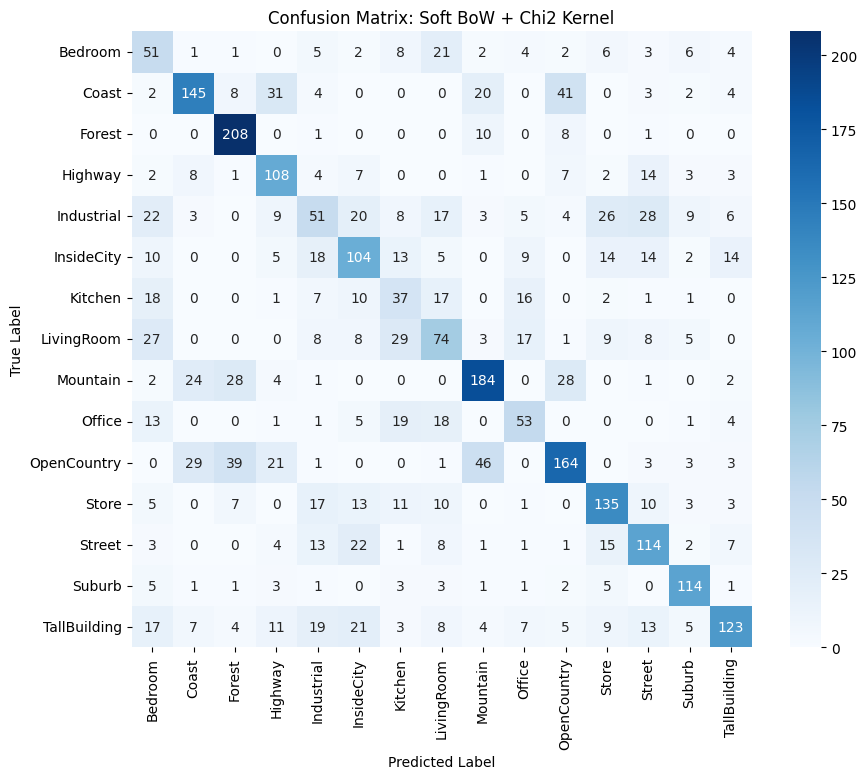

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import chi2_kernel

# ---------------------------------------------------------
# Step 6 + 8: SVM with Chi-Squared Kernel + Soft Assignment
# ---------------------------------------------------------

print("\n--- Combining Soft Assignment with Chi-Squared Kernel ---")

# 1. Use the RAW soft histograms (X_train_soft, X_test_soft)
# Ensure these were created using your extract_soft_bow_histogram function.
# These values are non-negative and sum to 1, which is perfect for Chi2.
X_train_final = X_train_soft
X_test_final = X_test_soft

# 2. Compute the Chi-Squared Kernel Matrix
# We use gamma=0.5 as a starting point.
# If accuracy is lower than expected, try gamma=0.1.
print("Computing Chi2 Kernel Matrices...")
K_train_soft = chi2_kernel(X_train_final, X_train_final, gamma=15)
K_test_soft = chi2_kernel(X_test_final, X_train_final, gamma=15)

# 3. Train the SVM with 'precomputed' kernel
# Using C=10.0 often works better for non-linear kernels on this dataset.
svm_soft_chi2 = SVC(kernel='precomputed', C=1000.0, random_state=RANDOM_SEED)

print("Training Non-Linear SVM...")
svm_soft_chi2.fit(K_train_soft, y_train_soft)

# 4. Predict and Evaluate
print("Predicting on Test Set...")
y_pred_soft_chi2 = svm_soft_chi2.predict(K_test_soft)

# 5. Accuracy Calculation
combined_acc = accuracy_score(y_test_soft, y_pred_soft_chi2)
print(f"\nAccuracy (Soft Assignment + Chi-Squared Kernel): {combined_acc * 100:.2f}%")

# 6. Confusion Matrix
plot_confusion_matrix(y_test_soft, y_pred_soft_chi2, categories, "Confusion Matrix: Soft BoW + Chi2 Kernel")

#### Chi squared distance + Soft assigment + spatial pyramid


--- Final Step: Spatial Pyramid + Soft Assignment + Chi-Squared SVM ---
Input Feature Shape: (1500, 750)
Computing Chi2 Kernel Matrices (gamma=1)...
Training Final SVM...
Predicting on Test Set...

Final Accuracy (SPM + Soft + Chi2): 51.22%


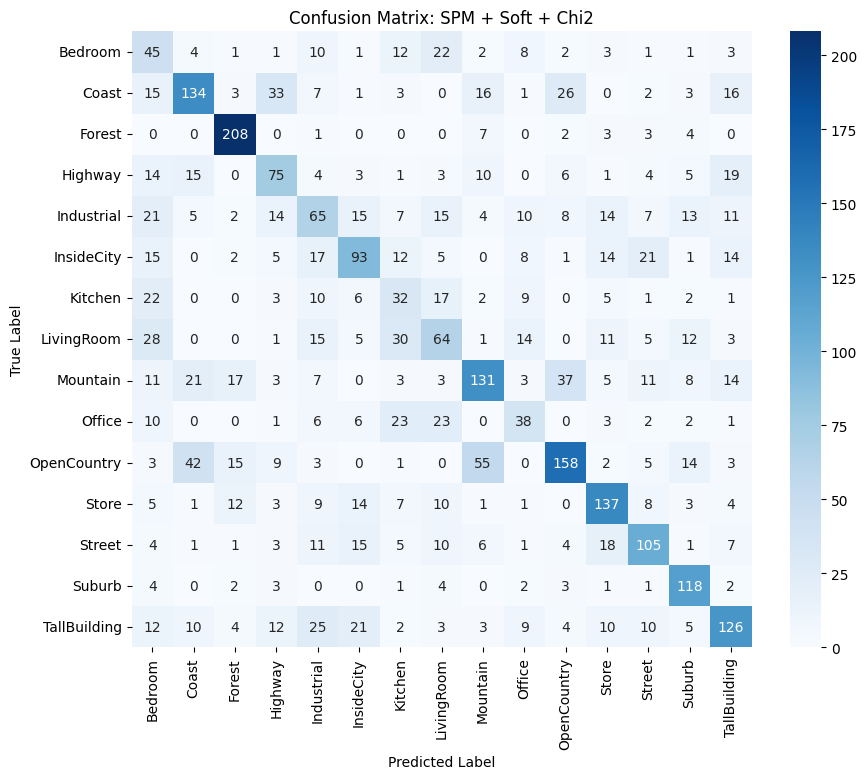

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import chi2_kernel

print("\n--- Final Step: Spatial Pyramid + Soft Assignment + Chi-Squared SVM ---")

# 1. Select the Data
# CRITICAL: Use the RAW 'X_train_spm' and 'X_test_spm' created in Step 9.2.
# Do NOT use 'X_train_spm_scaled' because Chi-Squared requires non-negative values.
# Your extract_spatial_pyramid_soft function already L1-normalized them, which is perfect.
X_train_final = X_train_spm
X_test_final = X_test_spm

print(f"Input Feature Shape: {X_train_final.shape}")
# Expected: (NumImages, 1000) -> 200 words * (1 level_0 + 4 level_1 quadrants)

# 2. Compute Chi-Squared Kernel Matrices
# Since we have higher dimensionality (1000 vs 200), we stick to gamma=0.5.
# If the accuracy is surprisingly low (like 33%), try lowering gamma to 0.1 or 0.05.
gamma_val = 1
print(f"Computing Chi2 Kernel Matrices (gamma={gamma_val})...")

K_train_spm_chi = chi2_kernel(X_train_final, X_train_final, gamma=gamma_val)
K_test_spm_chi = chi2_kernel(X_test_final, X_train_final, gamma=gamma_val)

# 3. Train the SVM
# We use C=10.0 to give the non-linear kernel flexibility.
print("Training Final SVM...")
svm_final = SVC(kernel='precomputed', C=900.0, random_state=RANDOM_SEED)
svm_final.fit(K_train_spm_chi, y_train)

# 4. Predict
print("Predicting on Test Set...")
y_pred_final = svm_final.predict(K_test_spm_chi)

# 5. Evaluate
final_acc = accuracy_score(y_test, y_pred_final)
print(f"\nFinal Accuracy (SPM + Soft + Chi2): {final_acc * 100:.2f}%")

# 6. Confusion Matrix
plot_confusion_matrix(y_test, y_pred_final, categories, "Confusion Matrix: SPM + Soft + Chi2")

#### Results Comparison

--- SUMMARY OF ACCURACIES ---
Baseline (k-NN)                : 37.72%
Linear SVM (OvR)               : 44.05%
Chi2 Kernel                    : 58.02%
ECOC (Hard)                    : 43.18%
Soft Assignment (Linear)       : 56.98%
SPM (Linear)                   : 57.35%
Chi2 SVM + Soft                : 55.78%
Final (SPM + Soft + Chi2)      : 51.22%


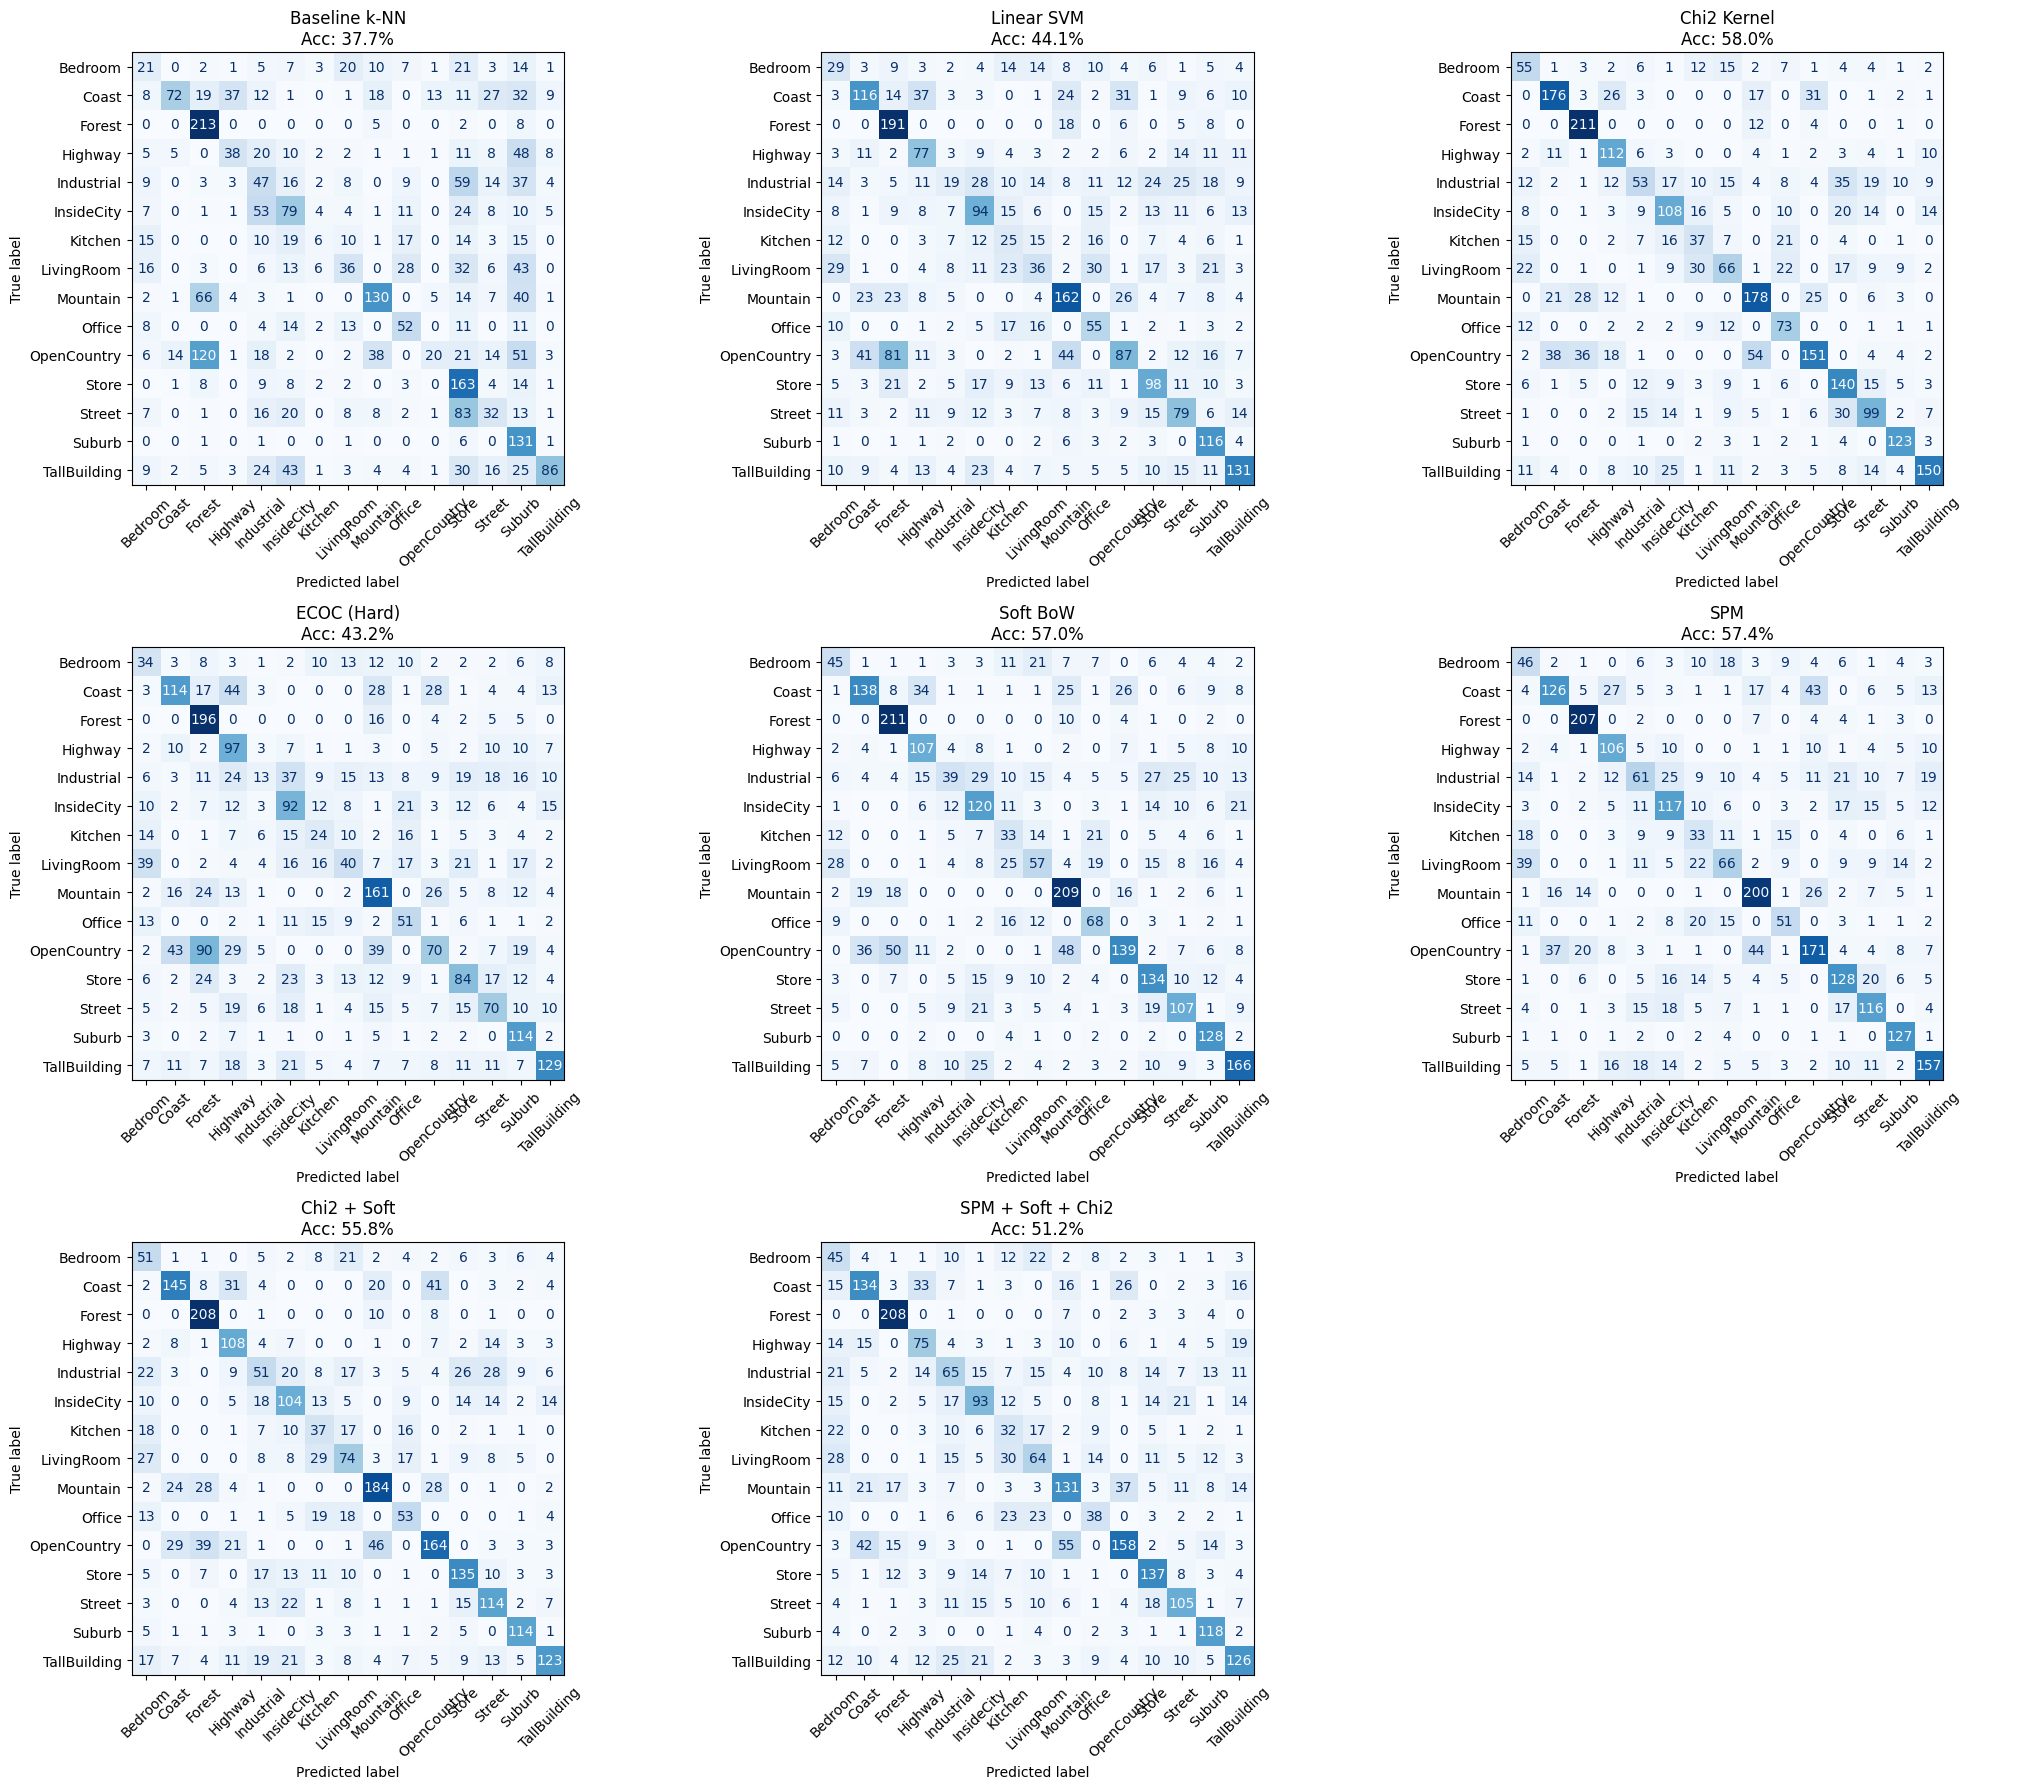

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# 1. Collect all accuracy results
# Replace the placeholder values with your actual variables
results = {
    "Baseline (k-NN)": accuracy,               # From Step 4
    "Linear SVM (OvR)": svm_acc,               # From Step 5
    "Chi2 Kernel": chi2_acc,                   # From Step 6
    "ECOC (Hard)": ecoc_acc,                   # From Step 7
    "Soft Assignment (Linear)": acc_soft,      # From Step 8
    "SPM (Linear)": spm_acc,                   # From Step 9
    "Chi2 SVM + Soft": combined_acc,           # From Step 6 + 8
    "Final (SPM + Soft + Chi2)": final_acc     # From Step 6 + 8 + 9
}

print("--- SUMMARY OF ACCURACIES ---")
for model, acc in results.items():
    print(f"{model:30} : {acc*100:.2f}%")

# 2. Function to plot multiple Confusion Matrices side-by-side
def plot_comparative_matrices(y_true, predictions_dict, categories):
    """
    predictions_dict: dictionary where keys are model names and
                      values are the y_pred arrays.
    """
    n_models = len(predictions_dict)
    cols = 3
    rows = (n_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 6 * rows))
    axes = axes.flatten()

    for i, (name, y_pred) in enumerate(predictions_dict.items()):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

        # Plot on specific axis
        disp.plot(ax=axes[i], cmap='Blues', xticks_rotation=45, colorbar=False)
        axes[i].set_title(f"{name}\nAcc: {accuracy_score(y_true, y_pred)*100:.1f}%")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 3. Execute comparison
# Map your model names to their prediction variables
all_preds = {
    "Baseline k-NN": y_pred_nn,                   # From Step 3
    "Linear SVM": y_pred_svm,                     # From Step 5
    "Chi2 Kernel": y_pred_chi2,                   # From Step 6
    "ECOC (Hard)": y_pred_ecoc,                   # From Step 7
    "Soft BoW": y_pred_soft,                      # From Step 8
    "SPM": y_pred_spm,                            # From Step 9
    "Chi2 + Soft": y_pred_soft_chi2,
    "SPM + Soft + Chi2": y_pred_final
}

plot_comparative_matrices(y_test, all_preds, categories)